In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
local_dir = '/content/drive/MyDrive/Acid Analysis/'

Mounted at /content/drive


In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px

In [16]:
antibody_to_uniprot = pd.read_csv(local_dir + 'antibody revised.csv')
antibody_to_uniprot

,Antibody Code,Antibody Name,Target Name,Pan or P-Site,Antibody Type,Target Full Name,Target Uniprot ID,Target Refseq ID
0,05-0073 (Clone 8F7),NaN,FAK (PTK2),Y397,NaN,NaN,Q05397,NaN
1,05-184,NaN,Src,Pan-specific,NaN,NaN,P12931,NaN
2,05-636,NaN,H2AFX (H2AX; Histone H2A.X),S139,NaN,NaN,P16104,NaN
3,05-746,NaN,Histone H3,T3,NaN,NaN,P84243,NaN
4,06-0020,NaN,Akt1 (PKBa),NaN,NaN,NaN,P31749,NaN
...,...,...,...,...,...,...,...,...
3785,sc-960,NaN,MKK3 (MAP2K3; MEK3),Pan-specific,NaN,NaN,P46734,NaN
3786,sc-964,NaN,MKK4 (MAP2K4; MEK4),Pan-specific,NaN,NaN,P45985,NaN
3787,sc-9898,NaN,Csk,Pan-specific,NaN,NaN,P41240,NaN
3788,sc-9968,NaN,CDKN2A (p16; p16-INK4a),Pan-specific,NaN,NaN,Q8N726,NaN


In [17]:
metadata = pd.read_excel(local_dir + 'CombinedArrays.xlsx', sheet_name='metadata')
data = pd.read_excel(local_dir + 'CombinedArrays.xlsx', sheet_name='data')

In [18]:
def rename_columns(df):
  new_cols = []
  last = ""
  for i in df.columns:
    if "Unnamed:" not in i:
      last = i

    if 'Barcode: #' in last:
      last = last.split('Barcode: #')[1]
    elif 'Barcode ' in last:
      last = last.split('Barcode ')[1]
    elif 'Barcode: ' in last:
      last = last.split('Barcode: ')[1]
    elif 'ID ' in last:
      last = last.split('ID ')[1]

    new_cols.append(last)

  df.iloc[:, :4] = df.iloc[:, :4].astype(str) # turn cat No. into a string
  df.iloc[:, 3] = df.iloc[:, 3].str.strip()

  multi_index = pd.MultiIndex.from_tuples(list(zip(new_cols, df.iloc[0])), names=['id', 'column'])
  df = df.iloc[1:]
  df.columns = multi_index

  return df

# Melt to combine data

In [19]:
def custom_melt(data):
  melt = rename_columns(data).melt(id_vars=[('Index', 'Cat No.')])
  melt = melt[melt['column'].isin(['Normalized', 'Flag'])]
  melt = melt.rename(columns={('Index', 'Cat No.'): 'antibody'})
  melt['replicate'] = melt.groupby(['antibody', 'id', 'column']).cumcount()
  melt = melt.pivot(index=['antibody', 'replicate', 'id'], columns='column', values='value').reset_index()
  return melt

first_melt = custom_melt(data)

In [23]:
metadata['Barcode'] = metadata['Barcode'].astype(str)
big_melt = metadata.merge(first_melt, how='inner', left_on='Barcode', right_on='id').drop(columns=['id'])
big_melt

,Sample ID,Treatment,Treatment Details,Barcode,antibody,replicate,Flag,Normalized
0,BJ_01,Untreated,Untreated rep 1,21403,05-184,0,1,313
1,BJ_01,Untreated,Untreated rep 1,21403,05-184,1,1,273
2,BJ_01,Untreated,Untreated rep 1,21403,05-746,0,0,799
3,BJ_01,Untreated,Untreated rep 1,21403,05-746,1,0,762
4,BJ_01,Untreated,Untreated rep 1,21403,06-2020,0,0,1566
...,...,...,...,...,...,...,...,...
48643,BJ_12,HCl,HCl rep 3,21414,sc-9898,1,0,457
48644,BJ_12,HCl,HCl rep 3,21414,sc-9968,0,1,170
48645,BJ_12,HCl,HCl rep 3,21414,sc-9968,1,1,188
48646,BJ_12,HCl,HCl rep 3,21414,sc-9970,0,0,180


In [24]:
exp_cols = ['Treatment']

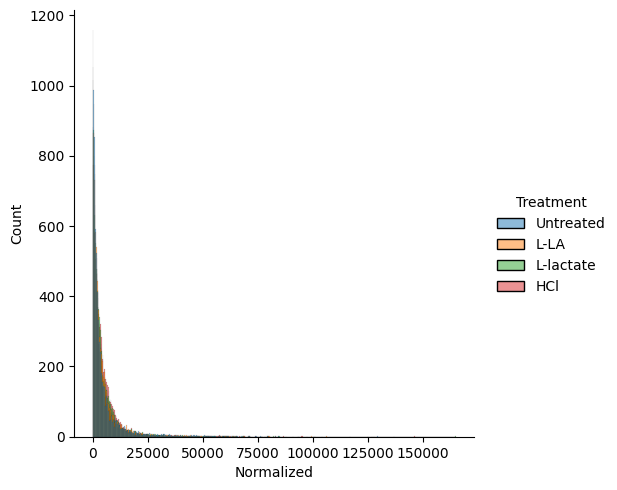

In [25]:
sns.displot(big_melt, x='Normalized', hue='Treatment', log_scale=(False, False))

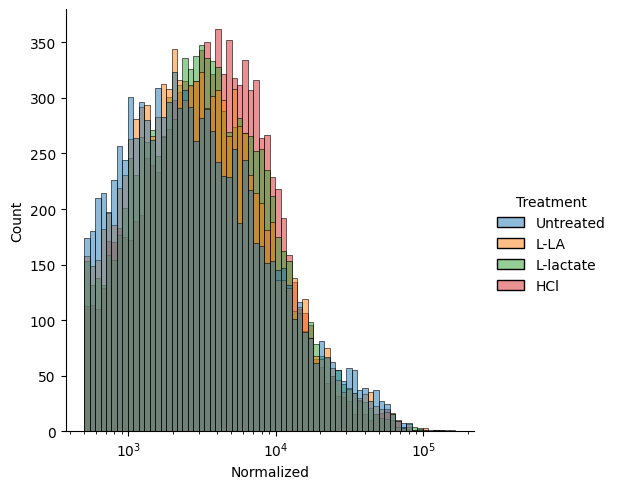

In [26]:
# include for jack
sns.displot(big_melt[big_melt['Normalized'] > 500], x='Normalized', hue='Treatment', log_scale=(True, False))

<Axes: xlabel='Normalized', ylabel='Count'>

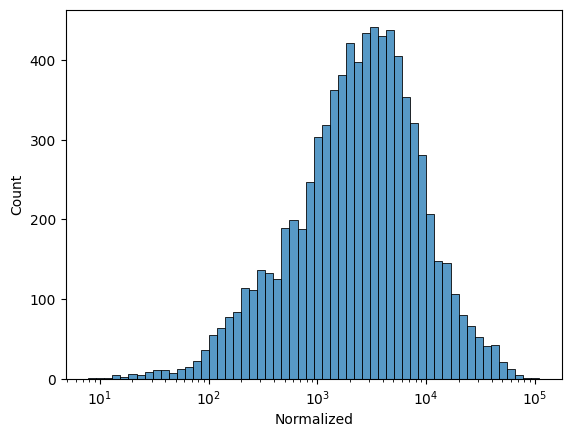

In [27]:
sns.histplot(big_melt.groupby(exp_cols + ['antibody'])['Normalized'].mean(), log_scale=(True, False))

<Axes: xlabel='Normalized', ylabel='Count'>

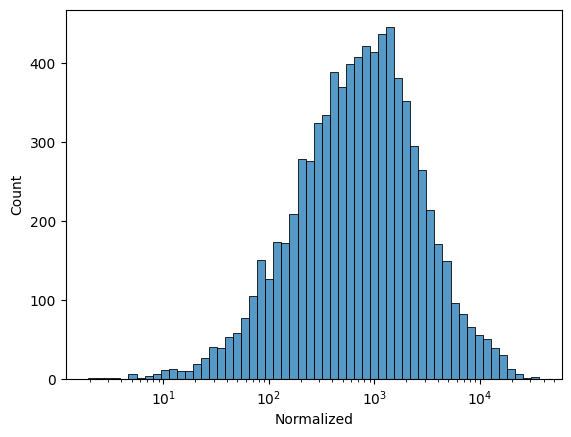

In [28]:
sns.histplot(big_melt.groupby(exp_cols + ['antibody'])['Normalized'].std(), log_scale=(True, False))

<Axes: ylabel='Frequency'>

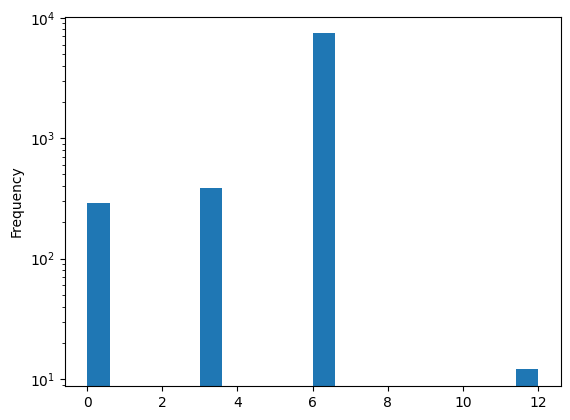

In [29]:
good_num = big_melt.groupby(exp_cols + ['antibody'])['Flag'].agg(lambda x: x.count()-x.sum())
good_num.plot.hist(logy=True, bins=20)

In [30]:
std = big_melt.groupby(exp_cols + ['antibody'])['Normalized'].std()
std

Treatment  antibody
HCl        05-184        92.410858
           05-746       225.598537
           06-2020      242.574868
           06-519      1544.976203
           06-570      1362.226768
                          ...     
Untreated  sc-960       153.066979
           sc-964        74.904606
           sc-9898      171.989535
           sc-9968       34.455769
           sc-9970       41.448764
Name: Normalized, Length: 8096, dtype: float64

In [31]:
px.density_heatmap(big_melt, x='Flag', y='replicate')

In [32]:
for i, G in list(big_melt.groupby(exp_cols + ['antibody']))[150:]:
  if not G['Flag'].any():
    continue

  display(G)
  break

,Sample ID,Treatment,Treatment Details,Barcode,antibody,replicate,Flag,Normalized
36830,BJ_10,HCl,HCl rep 1,21412,AP8076b,0,0,1830
36831,BJ_10,HCl,HCl rep 1,21412,AP8076b,1,1,676
40884,BJ_11,HCl,HCl rep 2,21413,AP8076b,0,0,1439
40885,BJ_11,HCl,HCl rep 2,21413,AP8076b,1,1,1731
44938,BJ_12,HCl,HCl rep 3,21414,AP8076b,0,0,758
44939,BJ_12,HCl,HCl rep 3,21414,AP8076b,1,1,1466


In [33]:
big_melt[big_melt['antibody'] == '2020-06']

,Sample ID,Treatment,Treatment Details,Barcode,antibody,replicate,Flag,Normalized


In [34]:
big_melt.to_csv(local_dir + 'melted.csv', index=False)

*   both replicates flagged? drop
*   one replicate flagged and similar to the other? fine, keep both
*   one replicate flagged and disimilar to the other? drop both
*   normalized signal < 500 on both drop


